# Greenland Ice Surface Temperature, Surface Albedo, and Water Vapor from MODIS Comparison Tool

This tool compares modeled Greenland ice surface temperature from the MERRA-2 reanalysis to observations of ice surface temperature from MODIS.

In [2]:
# Set conda environment and import necessary packages
# import hublib.use
# %use modgrnld_anaconda_6

import os, sys, shutil
from hublib.ui import Download

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

import math

import glob
from datetime import date, timedelta, datetime
import calendar

import netCDF4 

from netCDF4 import Dataset
import numpy as np
import pandas as pd

from pyproj import Proj, transform, Transformer

import pyproj
if pyproj.__version__[0] == '1':
    from pyproj import Proj, transform
elif pyproj.__version__[0] == '2':
    from pyproj import Transformer

sys.path.append('data')
import nsidc_download_tools
import raster
import bilinear_interpolate

import requests

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import mean_squared_error

from math import sqrt

import xskillscore as xs

from scipy.stats import pearsonr

import xarray as xr


<IPython.core.display.Javascript object>

## Setup
This cell defines the parameters that are used throughout the script. Here are the parameters that the user can choose to change:

1. **dataDir**: Path to the directory where data for this tool is stored. MERRA-2 data is stored in the *MERRA-2* subdirectory and MODGRNLD observational data products are stored in the *MODGRNLD* subdirectory, relative to this path.
2. **comparison_year**: Year for model-observation comparison.
3. **comparison_month**: Month for model-observation comparison.
4. **MERRA_url_template**: Template for the url where MERRA-2 model data products can be downloaded. This template must have two fields that are filled in by the script: (1) 4-digit year, (2) 2-digit month (with prepending zeros).
5. **MERRA_filename_template**: Template that describes the filename of the MERRA-2 model data products. This template must have three fields that are filled in by the script: (1) 4-digit year, (2) 2-digit month (with prepending zeros), (3) 2-digit day (with prepending zeros).
6. **debug_plots**: True/False boolean that turns plots on/off that are useful for debugging the tool.
7. **mask_colors**: Colors used for plotting the ice sheet mask.

# Montly assessment and Plotting

In [3]:
# GHub data directory
# dataDir = '/data/groups/ghub/tools/modgrnld'

dataDir = '/data/groups/ghub/tools/modgrnld'

# Year/month over which to do comparison
comparison_year = 2011
comparison_month = 9


# MERRA data to download from GES DISC
# MERRA_url_template = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2/M2SDNXSLV.5.12.4/{:4d}/{:02d}'
# MERRA_url_template = 'https://goldsmr2.gesdisc.eosdis.nasa.gov/data/MERRA_MONTHLY/MAIMNXINT.5.2.0/{:4d}/{:02d}'
# MERRA_filename_template = 'MERRA300.prod.assim.instM_2d_int_Nx.{:4d}{:02d}.hdf'


# MERRA2 data to download from GES DISC
# MERRA2_url_template = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2/M2SDNXSLV.5.12.4/{:4d}/{:02d}'
MERRA_url_template = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2/M2I1NXINT.5.12.4/{:4d}/{:02d}'
MERRA_filename_template = 'MERRA2_400.inst1_2d_int_Nx.{:4d}{:02d}{:02d}.nc4'



# Plotting
debug_plots = True
mask_colors = np.array([[1.0, 1.0, 1.0],   # ocean
                        [0.5, 0.3, 0.1],   # land
                        [0.8, 0.8, 0.8],   # ice
                        [  1,   1,   1],   #
                        [  1,   1,   1]])  #


## Query NSIDC for MODGRNLD data
Note that this searches specifically for version 1 of the MODGRNLD product on NSIDC. There may be a way to query NSIDC to find out what versions are available, rather than hardcoding a particular version to download.

In [4]:
# Find all files that match
filename_filter = 'MODGRNLD.{:4d}{:02d}.monthly.v01.1.nc'.format(comparison_year, comparison_month)
MODGRNLD_url_list = nsidc_download_tools.cmr_search('MODGRNLD', filename_filter=filename_filter)

# Look for the files in the data directory
MODGRNLD_url_list_download = list()
for url in MODGRNLD_url_list:
    filename = url.split('/')[-1]
    if not os.path.exists(dataDir + '/MODGRNLD/' + filename):
        MODGRNLD_url_list_download.append(url)
    else:
        print('{:60s} already downloaded'.format(filename))

if len(MODGRNLD_url_list_download) > 0:
    # Download the files to the current directory
    nsidc_download_tools.cmr_download(MODGRNLD_url_list_download)

    # Move downloaded files to the data directory
    for url in MODGRNLD_url_list_download:
        filename = url.split('/')[-1]
        shutil.move(filename, dataDir + '/MODGRNLD/' + filename)
    

Querying for data:
	https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=true&page_size=2000&short_name=MODGRNLD&version=001&version=01&version=1&temporal[]=2000-01-01T00:00:00Z,2100-12-31T23:59:59Z&options[producer_granule_id][pattern]=true&producer_granule_id[]=*MODGRNLD.201109.monthly.v01.1.nc*

Found 1 matches.
MODGRNLD.201109.monthly.v01.1.nc                             already downloaded
MODGRNLD.201109.monthly.v01.1.nc.xml                         already downloaded


## Read MERRA and MERRA-2 data
The MERRA-2 data product that we will use is the statistics of the single-level-variable (slv) collection, statD_2d_slv_Nx (https://dx.doi.org/10.5067/9SC1VNTWGWV3). These products contain daily averages of the temperature at various heights above the surface. We will use the 2-m temperature contained in the variable **T2MEAN**. We must download the daily-averaged MERRA-2 data and then average over the month.

In [5]:
# MERRA Download

MERRA_url_list_download = list()
# ndays = (date(comparison_year, comparison_month+1, 1) - date(comparison_year, comparison_month, 1)).days

ndays = calendar.monthrange(comparison_year, comparison_month)[1]

for day in range(1,ndays+1):
    MERRA_url = MERRA_url_template.format(comparison_year, comparison_month)
    MERRA_filename = MERRA_filename_template.format(comparison_year, comparison_month, day)
    if os.path.exists(dataDir + '/MERRA-2/' + MERRA_filename):
        print('{:60s} already downloaded'.format(MERRA_filename))
    else:
        MERRA_url_list_download.append(MERRA_url + '/' + MERRA_filename)

print('')
if len(MERRA_url_list_download) > 0:
    # Download the files to the current directory
    nsidc_download_tools.cmr_download(MERRA_url_list_download)
    
    # Move downloaded files to the data directory
    for url in MERRA_url_list_download:
        MERRA_filename = url.split('/')[-1]
        shutil.move(MERRA_filename, dataDir + '/MERRA-2/' + MERRA_filename)
        

MERRA2_400.inst1_2d_int_Nx.20110901.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110902.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110903.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110904.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110905.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110906.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110907.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110908.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110909.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110910.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110911.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110912.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110913.nc4 

In [9]:
# MERRA-2 Download

MERRA2_url_list_download = list()
# ndays = (date(comparison_year, comparison_month+1, 1) - date(comparison_year, comparison_month, 1)).days

ndays = calendar.monthrange(comparison_year, comparison_month)[1]

for day in range(1,ndays+1):
    MERRA2_url = MERRA_url_template.format(comparison_year, comparison_month)
    MERRA2_filename = MERRA_filename_template.format(comparison_year, comparison_month, day)
    if os.path.exists(dataDir + '/MERRA-2/' + MERRA2_filename):
        print('{:60s} already downloaded'.format(MERRA2_filename))
    else:
        MERRA2_url_list_download.append(MERRA2_url + '/' + MERRA2_filename)

print('')
if len(MERRA2_url_list_download) > 0:
    # Download the files to the current directory
    nsidc_download_tools.cmr_download(MERRA2_url_list_download)
    
    # Move downloaded files to the data directory
    for url in MERRA2_url_list_download:
        MERRA2_filename = url.split('/')[-1]
        shutil.move(MERRA2_filename, dataDir + '/MERRA-2/' + MERRA2_filename)
        

MERRA2_400.inst1_2d_int_Nx.20110901.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110902.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110903.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110904.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110905.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110906.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110907.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110908.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110909.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110910.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110911.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110912.nc4                      already downloaded
MERRA2_400.inst1_2d_int_Nx.20110913.nc4 

## Read Greenland Ice Sheet mask

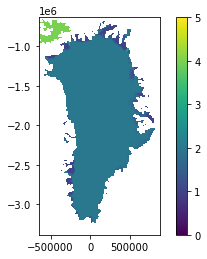

In [12]:
# GrIS ice mask
bedMachine_mask = dataDir + '/BedMachineGreenland-2017-09-20-Mask.tif.nc'
ds = Dataset(bedMachine_mask)
mask = ds['Band1'][:,:]
x_mask = ds['x'][:]
y_mask = ds['y'][:]
ds.close()

extent_mask = [x_mask[ 0]-(x_mask[ 1]-x_mask[ 0])/2, \
               x_mask[-1]+(x_mask[ 1]-x_mask[ 0])/2, \
               y_mask[-1]-(y_mask[-2]-y_mask[-1])/2, \
               y_mask[ 0]+(y_mask[-2]-y_mask[-1])/2]

if debug_plots:
    plt.imshow(mask[::10,::10], extent=extent_mask, vmin=0, vmax=5)
    plt.colorbar()
    plt.gca().invert_yaxis()

## Read MERRA-2 data

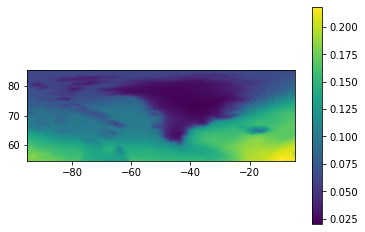

In [13]:
# MERRA-2
WV_MERRA_sum = None

ndays = calendar.monthrange(comparison_year, comparison_month)[1]

for day in range(1,ndays+1):
    MERRA_filename = MERRA_filename_template.format(comparison_year, comparison_month, day)
    MERRA_ncfile = dataDir + '/MERRA-2/' + MERRA_filename
    ds = Dataset(MERRA_ncfile)
    WV_MERRA = ds['TQV'][:,:,:]
    
    if day == 1:
        lat_MERRA = ds['lat'][:]
        lon_MERRA = ds['lon'][:]
        epsg_MERRA = 4326

    ds.close()
    
    # Daily average
    WV_MERRA_daily_avg = np.mean(WV_MERRA, axis=0)

    # Sum
    if WV_MERRA_sum is None:
        WV_MERRA_sum = WV_MERRA_daily_avg
    else:
        WV_MERRA_sum = WV_MERRA_sum + WV_MERRA_daily_avg

# Calculate the monthly mean
WV_MERRA_mean = WV_MERRA_sum / ndays

# Select points over Greenland
lat_min =  55.
lat_max =  85.
lon_min = -95.
lon_max =  -5.
row_min = np.where(lat_MERRA == lat_min)[0][0]
row_max = np.where(lat_MERRA == lat_max)[0][0]
col_min = np.where(lon_MERRA == lon_min)[0][0]
col_max = np.where(lon_MERRA == lon_max)[0][0]

WV_MERRA_mean = WV_MERRA_mean[row_min:row_max, col_min:col_max]
lat_MERRA = lat_MERRA[row_min:row_max]
lon_MERRA = lon_MERRA[col_min:col_max]
extent_MERRA = [lon_min - (lon_MERRA[1]-lon_MERRA[0])/2, \
                lon_max + (lon_MERRA[1]-lon_MERRA[0])/2, \
                lat_min - (lat_MERRA[1]-lat_MERRA[0])/2, \
                lat_max + (lat_MERRA[1]-lat_MERRA[0])/2]

# Convert kg/m-2 to cm of water
WV_MERRA_mean = WV_MERRA_mean * 0.01

# if debug_plots:
plt.imshow(WV_MERRA_mean, origin='lower', extent=extent_MERRA)
plt.colorbar()


In [14]:
WV_MERRA_mean.shape

(60, 144)

## Read MODGRNLD data


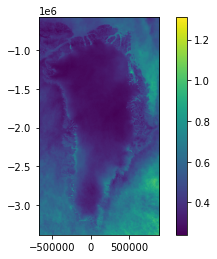

In [15]:
# MODGRNLD
ulx, uly = -675000.0, -575000.0 # from user's guide on NSIDC
lrx, lry = 887500.0, -3387500.0
res = 781.25 # grid resolution
x_MODIS = np.arange(ulx,lrx,res)
y_MODIS = np.arange(lry,uly,res)
extent_MODIS = [ulx-res/2, lrx+res/2, lry-res/2, uly+res/2]
epsg_MODIS = 3411

# Calculate monthly average
ncfilename = [url.split('/')[-1] for url in MODGRNLD_url_list if url.endswith('.nc')][0]

ds = Dataset(dataDir + '/MODGRNLD/' + ncfilename)
WV_MODIS_mean = ds['Water_Vapor_Near_Infrared_Mean'][0,:,:]
ds.close()

# WV_MODIS_mean = WV_MODIS_mean * 10.

# WV_MODIS_mean[WV_MODIS_mean== 0.] = np.nan
# WV_MODIS_mean[WV_MODIS_mean==50.] = np.nan 

# if debug_plots:
plt.imshow(WV_MODIS_mean[::10,::10], extent=extent_MODIS)
plt.colorbar()

In [16]:
WV_MODIS_mean.shape

(3600, 2000)

### <span style='background :yellow'><span style='color:Red'>CAUTION:</span></span> Check the number of days that were used in the monthy average for the MODGRNLD product.
The product is an "opportunistic" average in that it calculates the average monthly temperature within a given pixel using any available daily observations. The spatiotemporal distribution of daily observations might be heterogeneous across the ice sheet and this needs to be taken into account when interpreting model-observation differences. Here, we plot the number of days that were used to calculate the monthly average, giving one indicator of how representative the calculated monthly average is of the true monthly average. To investigate whether the calculated monthly average is biased in time, one would need to download the daily data products and identify the days for which data exists for each pixel.

This plot is diagnostic and is displayed for the user's interpretation. It is not available for download in this current version of the tool.

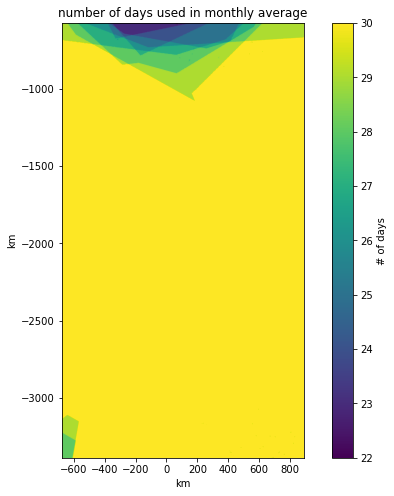

In [17]:
# WV_Temperature_Mean_Ndays
ds = Dataset(dataDir + '/MODGRNLD/' + ncfilename)
MODGRNLD_Ndays = ds['Water_Vapor_Near_Infrared_Mean_Ndays'][0,:,:]
ds.close()

plt.figure(num=None, figsize=(10, 8))
plt.imshow(MODGRNLD_Ndays[::1,::1], extent=[e/1000. for e in extent_MODIS])
cbar = plt.colorbar()
cbar.ax.set_ylabel('# of days')
plt.title('number of days used in monthly average')
plt.xlabel('km')
plt.ylabel('km')
plt.show()

## Interpolate MERRA-2 and MODGRNLD data to a common grid

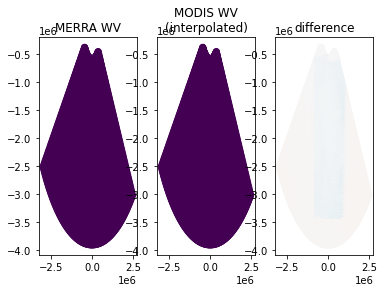

In [18]:
# Project MERRA-2 values onto the MODIS polar stereographic projection
lonm_MERRA, latm_MERRA = np.meshgrid(lon_MERRA, lat_MERRA)

if pyproj.__version__[0] == '1':
    lonm_MERRA, latm_MERRA = np.meshgrid(lon_MERRA, lat_MERRA)
    xm_MERRA, ym_MERRA = transform(Proj(init="epsg:4326"), Proj(init="epsg:3413"), lonm_MERRA, latm_MERRA)
else:
    transformer = Transformer.from_crs("epsg:4326", "epsg:3411")
    xm_MERRA, ym_MERRA = transformer.transform(latm_MERRA, lonm_MERRA)

# Bilinearly interpolate MODIS grid to MERRA-2 poinWV
gt_MODIS = raster.extent2gt(WV_MODIS_mean, extent_MODIS)
i_MERRA, j_MERRA = raster.map2pixel(xm_MERRA, ym_MERRA, gt_MODIS)
WV_MODIS_interp = bilinear_interpolate.bilinear_interpolate(WV_MODIS_mean, i_MERRA, j_MERRA)

# Calculate the differences
WV_diff = WV_MODIS_interp - WV_MERRA_mean

if debug_plots:
    fig, ax = plt.subplots(1,3)
    im2 = ax[0].scatter(xm_MERRA, ym_MERRA, c=WV_MERRA_mean,   vmin=210, vmax=270)
    im1 = ax[1].scatter(xm_MERRA, ym_MERRA, c=WV_MODIS_interp, vmin=210, vmax=270)
    im3 = ax[2].scatter(xm_MERRA, ym_MERRA, c=WV_diff, cmap='RdBu', vmin=-10, vmax=+10)

    ax[0].set_title('MERRA WV')
    ax[1].set_title('MODIS WV\n(interpolated)')
    ax[2].set_title('difference')



## Plot MERRA-2 and MODGRNLD data and ice sheet surface temperature difference

Text(0.5, 1.0, 'difference')

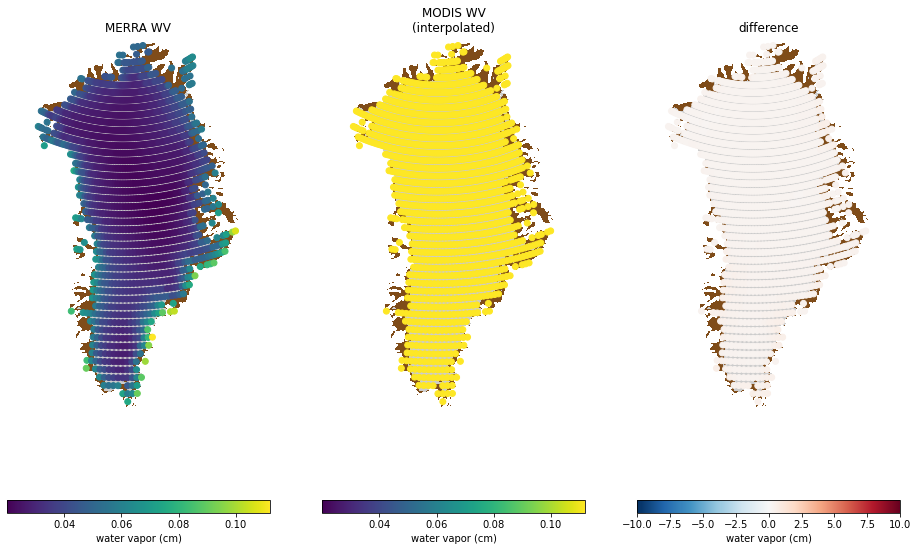

In [19]:
# Project MERRA-2 values onto the BedMachine polar stereographic projection
lonm_MERRA, latm_MERRA = np.meshgrid(lon_MERRA, lat_MERRA)
if pyproj.__version__[0] == '1':
    lonm_MERRA, latm_MERRA = np.meshgrid(lon_MERRA, lat_MERRA)
    xm_MERRA, ym_MERRA = transform(Proj(init="epsg:4326"), Proj(init="epsg:3413"), lonm_MERRA, latm_MERRA)
elif pyproj.__version__[0] == '2':
    transformer = Transformer.from_crs("epsg:4326", "epsg:3411")
    xm_MERRA, ym_MERRA = transformer.transform(latm_MERRA, lonm_MERRA)

# Bilinearly interpolate BedMachine grid to MERRA-2 poinWV
gt_mask = raster.extent2gt(mask, extent_mask)
i_MERRA, j_MERRA = raster.map2pixel(xm_MERRA, ym_MERRA, gt_mask)
mask_interp = bilinear_interpolate.bilinear_interpolate(mask, i_MERRA, j_MERRA)
ice_interp = mask_interp == 2

# Mask out poinWV off ice
WV_MERRA_masked = WV_MERRA_mean
WV_MERRA_masked[np.logical_not(ice_interp)] = np.nan
WV_MODIS_masked = WV_MODIS_interp
WV_MODIS_masked[np.logical_not(ice_interp)] = np.nan
WV_diff_masked = WV_diff
WV_diff_masked[np.logical_not(ice_interp)] = np.nan

cm = LinearSegmentedColormap.from_list('mask', mask_colors, N=5)

fig, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(mask[::10,::10], extent=extent_mask, cmap=cm, vmin=0, vmax=5)
im1 = ax[0].scatter(xm_MERRA, ym_MERRA, c=WV_MERRA_mean)
ax[0].invert_yaxis()
ax[1].imshow(mask[::10,::10], extent=extent_mask, cmap=cm, vmin=0, vmax=5)
im2 = ax[1].scatter(xm_MERRA, ym_MERRA, c=WV_MODIS_interp, vmin=im1.get_clim()[0], vmax=im1.get_clim()[1])
ax[1].invert_yaxis()
ax[2].imshow(mask[::10,::10], extent=extent_mask, cmap=cm, vmin=0, vmax=5)
im3 = ax[2].scatter(xm_MERRA, ym_MERRA, c=WV_diff, cmap=plt.cm.get_cmap('RdBu').reversed(), vmin=-10, vmax=+10)
ax[2].invert_yaxis()

cbar1 = fig.colorbar(im1, ax=ax[0], orientation='horizontal')
cbar2 = fig.colorbar(im2, ax=ax[1], orientation='horizontal')
cbar3 = fig.colorbar(im3, ax=ax[2], orientation='horizontal')
cbar1.ax.set_xlabel('water vapor (cm)')
cbar2.ax.set_xlabel('water vapor (cm)')
cbar3.ax.set_xlabel('water vapor (cm)')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[0].set_title('MERRA WV')
ax[1].set_title('MODIS WV\n(interpolated)')
ax[2].set_title('difference')

# plot_filename = 'MODGRNLD_MERRA_MODIS_WV_comparison_map.pdf'
# plt.savefig(plot_filename)
# Download(plot_filename, label='Download plot')

## Calculate and plot statistics

In [20]:
# Fix array size
WV_MODIS_masked_nonan = WV_MODIS_masked[np.logical_not(np.isnan(WV_MODIS_masked))]
WV_MERRA_masked_nonan = WV_MERRA_masked[np.logical_not(np.isnan(WV_MERRA_masked))]

# Convert tuple to int
size = int(''.join(map(str, WV_MODIS_masked_nonan.shape)))
data = WV_MODIS_masked_nonan
xloc = np.arange(size)
newsize = int(''.join(map(str, WV_MERRA_masked_nonan.shape)))
new_xloc = np.linspace(0, size, newsize)
new_data = np.interp(new_xloc, xloc, data)

WV_MODIS_masked_nonan_int = new_data

In [21]:
WV_MODIS_masked_nonan_int.shape

(1723,)

In [22]:
WV_MERRA_masked_nonan.shape

(1723,)

MODIS [minus] MERRA-2 statistics:
 mean =  +0.31 cm
 stdv =  +0.07 cm
 Pearsons correlation =  +0.81
 RMSE =  +0.56


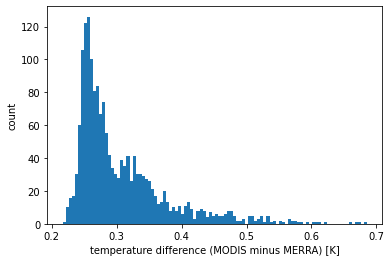

In [23]:
# Remove the nans (off-ice poinWV)
WV_diff_masked_nonan = WV_diff_masked[np.logical_not(np.isnan(WV_diff_masked))]

# Histogram
n, bins, patches = plt.hist(WV_diff_masked_nonan, bins=100)
plt.xlabel('temperature difference (MODIS minus MERRA) [K]')
plt.ylabel('count')

# Statistics
WV_diff_mean = np.mean(WV_diff_masked_nonan)
WV_diff_stdv = np.std(WV_diff_masked_nonan)
WV_diff_corr = np.corrcoef(WV_diff_masked_nonan)


WV_diff_mean_10_12 = WV_diff_mean
WV_diff_stdv_10_12 = WV_diff_stdv
# calculate Pearson's correlation
corr, _ = pearsonr(WV_MODIS_masked_nonan_int, WV_MERRA_masked_nonan)

mse = mean_squared_error(WV_MODIS_masked_nonan_int, WV_MERRA_masked_nonan , squared=False)
rmse = sqrt(mse)

# WV_diff_corr_10_12 = WV_diff_corr



print('MODIS [minus] MERRA-2 statistics:')
print(' mean = {:+6.2f} cm'.format(WV_diff_mean))
print(' stdv = {:+6.2f} cm'.format(WV_diff_stdv))
print(' Pearsons correlation = {:+6.2f}'.format(corr))
print(' RMSE = {:+6.2f}'.format(rmse))


# plot_filename = 'MODGRNLD_MERRA_MODIS_WV_comparison_histogram.pdf'
# # plt.savefig(plot_filename)
# Download(plot_filename, label='Download plot')